## Face Recognition Pipeline

Download the CelebA-HQ small subset
with annotations from here: https://tinyurl.com/
celebahqsmall.

In [4]:
import pandas as pd

CSV_FILE = '../data/CelebA-HQ-small.csv'
IMG_DIR = '../data/CelebA-HQ-small'


df = pd.read_csv(CSV_FILE)
train_df = df[df['split'] == 'train']
test_df = df[df['split'] == 'test']

print(f"Train test split: {len(train_df) / len(df):.2f}")

Train test split: 0.54


### 1. Face detection

- Use the Viola-Jones algorithm for face detection.
- Optimize its parameters for the best performance
on the training part of the dataset.
- Report detection metrics using Intersection over
Union (IoU).

In [5]:
import cv2
import numpy as np
import time


def iou(box_1, box_2):
    # bounding boxes in (x, y, w, h) format
    x1 = max(box_1[0], box_2[0])
    y1 = max(box_1[1], box_2[1])
    x2 = min(box_1[0] + box_1[2], box_2[0] + box_2[2])
    y2 = min(box_1[1] + box_1[3], box_2[1] + box_2[3])

    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    box_1_area = box_1[2] * box_1[3]
    box_2_area = box_2[2] * box_2[3]
    union = box_1_area + box_2_area - intersection

    if union != 0:
        return intersection / union
    else:
        return 0


class ViolaJonesDetector:
    def __init__(self):
        self.cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

    def detect_face(self, image, scale_factor=1.1, min_neighbors=7, min_size=(20, 20)):  # optimal configuration
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = self.cascade.detectMultiScale(
            gray,
            scaleFactor=scale_factor,
            minNeighbors=min_neighbors,
            minSize=min_size
        )

        if len(faces) == 0:
            return None
        else:
            return faces[0]

    def evaluate(self, dataframe, image_dir, scale_factor, min_neighbors, min_size):
        start_time = time.time()
        iou_scores = []
        for _, row in dataframe.iterrows():
            # read image
            image_idx = row['idx']
            image_path = f"{image_dir}/{image_idx}.jpg"
            image_box = (row['x_1'], row['y_1'], row['width'], row['height'])

            # detect face bounding box
            image = cv2.imread(image_path)
            detected_box = self.detect_face(
                image,
                scale_factor=scale_factor,
                min_neighbors=min_neighbors,
                min_size=min_size
            )

            if detected_box is not None:
                iou_scores.append(iou(detected_box, image_box))
            else:
                iou_scores.append(0.0)

        evaluation_time = time.time() - start_time
        return np.mean(iou_scores), evaluation_time


detector = ViolaJonesDetector()
# default configuration
scale_factor = 1.1
min_neighbors = 5
min_size = (30, 30)

# train_iou, eval_time = detector.evaluate(train_df, IMG_DIR, scale_factor, min_neighbors, min_size)
# print(f"IoU score: {train_iou:.3f}, evaluation time: {eval_time:.3f} seconds")

```txt
IoU score: 0.655, evaluation time: 26.480 seconds
```

Parameter grid search

In [6]:
def viola_grid_search():
    scale_factor_values = [1.05, 1.1, 1.2]
    min_neighbors_values = [3, 5, 7]
    min_size_values = [(20, 20), (30, 30), (40, 40)]

    best_iou = 0
    best_config = None
    for scale_factor in scale_factor_values:
        for min_neighbors in min_neighbors_values:
            for min_size in min_size_values:
                train_iou, eval_time = detector.evaluate(train_df, IMG_DIR, scale_factor, min_neighbors, min_size)
                if train_iou > best_iou:
                    best_iou = train_iou
                    best_config = {'scale_factor': scale_factor,
                                   'min_neighbors': min_neighbors,
                                   'min_size': min_size}
                print(
                    f"Config: scale_factor={scale_factor}, min_neighbors={min_neighbors}, min_size={min_size} => Result: IoU={train_iou:.3f}, eval_time={eval_time:.3f}s")
    return best_config, best_iou

# best_config, best_iou = viola_grid_search()
# print(f"Best config: {best_config}, IoU score: {best_iou:.3f}")

```text
Config: scale_factor=1.05, min_neighbors=3, min_size=(20, 20) => Result: IoU=0.586, eval_time=63.286s
Config: scale_factor=1.05, min_neighbors=3, min_size=(30, 30) => Result: IoU=0.625, eval_time=50.953s
Config: scale_factor=1.05, min_neighbors=3, min_size=(40, 40) => Result: IoU=0.629, eval_time=45.876s
Config: scale_factor=1.05, min_neighbors=5, min_size=(20, 20) => Result: IoU=0.641, eval_time=62.373s
Config: scale_factor=1.05, min_neighbors=5, min_size=(30, 30) => Result: IoU=0.650, eval_time=51.126s
Config: scale_factor=1.05, min_neighbors=5, min_size=(40, 40) => Result: IoU=0.653, eval_time=44.953s
Config: scale_factor=1.05, min_neighbors=7, min_size=(20, 20) => Result: IoU=0.659, eval_time=63.365s
Config: scale_factor=1.05, min_neighbors=7, min_size=(30, 30) => Result: IoU=0.667, eval_time=51.343s
Config: scale_factor=1.05, min_neighbors=7, min_size=(40, 40) => Result: IoU=0.657, eval_time=45.393s
Config: scale_factor=1.1, min_neighbors=3, min_size=(20, 20) => Result: IoU=0.642, eval_time=33.318s
Config: scale_factor=1.1, min_neighbors=3, min_size=(30, 30) => Result: IoU=0.645, eval_time=24.989s
Config: scale_factor=1.1, min_neighbors=3, min_size=(40, 40) => Result: IoU=0.650, eval_time=22.772s
Config: scale_factor=1.1, min_neighbors=5, min_size=(20, 20) => Result: IoU=0.664, eval_time=33.407s
Config: scale_factor=1.1, min_neighbors=5, min_size=(30, 30) => Result: IoU=0.652, eval_time=26.895s
Config: scale_factor=1.1, min_neighbors=5, min_size=(40, 40) => Result: IoU=0.663, eval_time=25.873s
Config: scale_factor=1.1, min_neighbors=7, min_size=(20, 20) => Result: IoU=0.673, eval_time=33.752s
Config: scale_factor=1.1, min_neighbors=7, min_size=(30, 30) => Result: IoU=0.664, eval_time=26.332s
Config: scale_factor=1.1, min_neighbors=7, min_size=(40, 40) => Result: IoU=0.669, eval_time=24.015s
Config: scale_factor=1.2, min_neighbors=3, min_size=(20, 20) => Result: IoU=0.665, eval_time=19.902s
Config: scale_factor=1.2, min_neighbors=3, min_size=(30, 30) => Result: IoU=0.661, eval_time=15.930s
Config: scale_factor=1.2, min_neighbors=3, min_size=(40, 40) => Result: IoU=0.663, eval_time=15.374s
Config: scale_factor=1.2, min_neighbors=5, min_size=(20, 20) => Result: IoU=0.666, eval_time=20.155s
Config: scale_factor=1.2, min_neighbors=5, min_size=(30, 30) => Result: IoU=0.667, eval_time=15.990s
Config: scale_factor=1.2, min_neighbors=5, min_size=(40, 40) => Result: IoU=0.667, eval_time=15.180s
Config: scale_factor=1.2, min_neighbors=7, min_size=(20, 20) => Result: IoU=0.657, eval_time=20.142s
Config: scale_factor=1.2, min_neighbors=7, min_size=(30, 30) => Result: IoU=0.656, eval_time=15.957s
Config: scale_factor=1.2, min_neighbors=7, min_size=(40, 40) => Result: IoU=0.656, eval_time=15.353s
Best config: {'scale_factor': 1.1, 'min_neighbors': 7, 'min_size': (20, 20)}, IoU score: 0.673
```

keep VJ in the comparison, but add at least two DL
approaches. By default these are YOLO (https://docs.ultralytics.com/) and detection part of Insightface’s
model (https://github.com/deepinsight/insightface) –
for both see the examples on Eučilnica, but feel free
to use anything else

In [7]:
from ultralytics import YOLO


# YOLO DL model
class YoloDetector:
    # specify the model to use
    def __init__(self, model_name="yolov8n-face.pt"):
        self.model = YOLO(model_name)

    def detect_face(self, image):
        results = self.model(image, verbose=False)
        best_box = None
        best_conf = -1
        for result in results:
            for box in result.boxes:
                cls_id = int(box.cls[0])
                conf = float(box.conf[0])
                # face class id is 0
                if cls_id == 0 and conf > best_conf:
                    x1, y1, x2, y2 = map(int, box.xyxy[0])
                    # convert to (x, y, w, h) format
                    best_box = (x1, y1, x2 - x1, y2 - y1)
                    best_conf = conf
        return best_box

    def evaluate(self, dataframe, image_dir):
        start_time = time.time()
        iou_scores = []
        for _, row in dataframe.iterrows():
            # read image
            image_idx = row['idx']
            image_path = f"{image_dir}/{image_idx}.jpg"
            image_box = (row['x_1'], row['y_1'], row['width'], row['height'])

            # detect face bounding box
            image = cv2.imread(image_path)
            detected_box = self.detect_face(
                image,
            )

            if detected_box is not None:
                iou_scores.append(iou(detected_box, image_box))
            else:
                iou_scores.append(0.0)

        evaluation_time = time.time() - start_time
        return np.mean(iou_scores), evaluation_time


yolov8_detector = YoloDetector()
yolov12_detector = YoloDetector("yolov12s-face.pt")

# test_iou, eval_time = yolov8_detector.evaluate(test_df, IMG_DIR)
# print(f"YOLOv8 IoU score: {test_iou:.3f}, evaluation time: {eval_time:.3f} seconds")
#
# test_iou, eval_time = yolov12_detector.evaluate(test_df, IMG_DIR)
# print(f"YOLOv12 IoU score: {test_iou:.3f}, evaluation time: {eval_time:.3f} seconds")

```text
YOLOv8 IoU score: 0.853, evaluation time: 25.894 seconds
YOLOv12 IoU score: 0.855, evaluation time: 70.072 seconds
```

In [8]:
import insightface


# InsightFace DL model
class InsightDetector:
    # reduced detection size by half
    def __init__(self, model_name="buffalo_l", ctx_id=0, det_size=(320, 320)):
        self.model = insightface.app.FaceAnalysis(name=model_name, provider='CPUExecutionProvider')
        self.model.prepare(ctx_id=ctx_id, det_size=det_size)

    def detect_face(self, image):
        faces = self.model.get(image)
        if not faces:
            return None

        best_face = max(faces, key=lambda f: f.det_score)
        x1, y1, x2, y2 = map(int, best_face.bbox)
        best_box = (x1, y1, x2 - x1, y2 - y1)
        return best_box

    def evaluate(self, dataframe, image_dir):
        start_time = time.time()
        iou_scores = []
        for _, row in dataframe.iterrows():
            # read image
            image_idx = row['idx']
            image_path = f"{image_dir}/{image_idx}.jpg"
            image_box = (row['x_1'], row['y_1'], row['width'], row['height'])

            # detect face bounding box
            image = cv2.imread(image_path)
            detected_box = self.detect_face(
                image,
            )

            if detected_box is not None:
                iou_scores.append(iou(detected_box, image_box))
            else:
                iou_scores.append(0.0)

        evaluation_time = time.time() - start_time
        return np.mean(iou_scores), evaluation_time


insight_detector = InsightDetector()

# test_iou, eval_time = insight_detector.evaluate(test_df, IMG_DIR)
# print(f"InsightFace IoU score: {test_iou:.3f}, evaluation time: {eval_time:.3f} seconds")

C:\Users\tjasa\miniconda3\envs\cv\Lib\site-packages\onnxruntime\capi\onnxruntime_inference_collection.py:123: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\tjasa/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\tjasa/.insightface\models\buffalo_l\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\tjasa/.insightface\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\tjasa/.insightface\models\buffalo_l\genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\tjasa/.insightface\models\buffalo_l\w600k_r50.onnx recognition ['None', 3, 112, 112] 127.

```text
InsightFace IoU score: 0.861, evaluation time: 55.190 seconds
```

This is the best detector.

### 2. Feature extraction

- Select and implement at least three feature
extraction methods for face recognition. You may
Fig. 1. Example of face detection during November.
use implementations available in popular libraries
(e.g., Scikit-learn, OpenCV).
-  Probably the easiest to use methods:
    - Local Binary Patterns (LBP),
    - Histogram of Oriented Gradients (HOG),
    - Dense SIFT (using a fixed grid instead of
keypoint detectors).

In [9]:
import os
from skimage.feature import local_binary_pattern


# Local Binary Patterns
class LBPExtractor:
    def __init__(self, n_neighbors=24, radius=3):
        self.n_neighbors = n_neighbors
        self.radius = radius

    def extract(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        lbp = local_binary_pattern(gray, self.n_neighbors, self.radius, method='uniform')
        hist, _ = np.histogram(lbp.ravel(),
                               bins=np.arange(0, self.n_neighbors + 3),
                               range=(0, self.n_neighbors + 2))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-10)
        return hist

    # chi square distance
    def compare(self, features_1, features_2):
        return 0.5 * np.sum(((features_1 - features_2) ** 2) / (features_1 + features_2 + 1e-10))


# compute rank-1 and rank-5 accuracy
def evaluate_extractor(extractor, dataframe, image_dir, save_dir, detector=None):
    start_time = time.time()
    features = []
    labels = []

    for _, row in dataframe.iterrows():
        try:
            image_idx = row['idx']
            image_path = f"{image_dir}/{image_idx}.jpg"
            image = cv2.imread(image_path)

            if detector is not None:
                detected_box = detector.detect_face(image)
                if detected_box is not None:
                    # crop image
                    x, y, w, h = detected_box
                    image = image[y:y + h, x:x + w]

            features.append(extractor.extract(image))
            labels.append(row['identity'])
        except Exception as error:
            print(error)
            continue

    features = np.array(features)
    labels = np.array(labels)
    n_images = len(features)
    rank_1_correct = 0
    rank_5_correct = 0
    distance_matrix = np.zeros((n_images, n_images))

    # compute distances
    for i in range(n_images):
        distance_matrix[i, i] = np.inf  # distance to self
        for j in range(i + 1, n_images):
            distance = extractor.compare(features[i], features[j])
            distance_matrix[i, j] = distance
            distance_matrix[j, i] = distance

    # save labels and distance matrix as txt
    os.makedirs(save_dir, exist_ok=True)
    np.savetxt(f"{save_dir}/distance_matrix.txt", distance_matrix)
    np.savetxt(f"{save_dir}/labels.txt", labels, fmt='%s')

    # compute accuracy
    for i in range(n_images):
        sorted_indices = np.argsort(distance_matrix[i])
        sorted_labels = labels[sorted_indices]
        if labels[i] == sorted_labels[0]:
            rank_1_correct += 1
        if labels[i] in sorted_labels[:5]:
            rank_5_correct += 1
    rank_1_acc = rank_1_correct / n_images
    rank_5_acc = rank_5_correct / n_images
    evaluation_time = time.time() - start_time
    return rank_1_acc, rank_5_acc, evaluation_time


lbp_extractor = LBPExtractor()

rank1_acc, rank5_acc, eval_time = evaluate_extractor(lbp_extractor, test_df, IMG_DIR, '../out/lbp')
print(f"LBP Extractor: rank_1_acc={rank1_acc:.3f}, rank_5_acc={rank5_acc:.3f}, eval_time={eval_time:.3f}s")

rank1_acc, rank5_acc, eval_time = evaluate_extractor(lbp_extractor, test_df, IMG_DIR, '../out/lbpd', detector=insight_detector)
print(f"With Detector: rank_1_acc={rank1_acc:.3f}, rank_5_acc={rank5_acc:.3f}, eval_time={eval_time:.3f}s")

LBP Extractor: rank_1_acc=0.141, rank_5_acc=0.311, eval_time=162.562s


C:\Users\tjasa\miniconda3\envs\cv\Lib\site-packages\insightface\utils\transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


With Detector: rank_1_acc=0.187, rank_5_acc=0.333, eval_time=118.535s


```text
LBP Extractor: rank_1_acc=0.141, rank_5_acc=0.311, eval_time=153.829s
With Detector: rank_1_acc=0.187, rank_5_acc=0.333, eval_time=111.800s
```

An example of Faceinsight’s recognition model
is available on Eučilnica. But it is your task to
find the second (or more) face recognition model.
Make sure you have correct weights and that you
take feature vector (embedding) as the output
and not the final class-predictions that usually
come after fully-connected layers in CNNs

In [10]:
import torch


# InsightFace DL model
class InsightExtractor:
    def __init__(self, model_name="buffalo_l", ctx_id=0, det_size=(640, 640)):
        self.model = insightface.app.FaceAnalysis(name=model_name, providers=['CPUExecutionProvider'])
        self.model.prepare(ctx_id=ctx_id, det_size=det_size)

    def extract(self, image):
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        with torch.no_grad():
            embedding = self.model.models['recognition'].get_feat(rgb_image).flatten()
        # normalize and return embedding
        embedding = embedding.astype(np.float32)
        embedding /= (np.linalg.norm(embedding) + 1e-10)
        return embedding

    # cosine distance
    def compare(self, features_1, features_2):
        return 1 - np.dot(features_1, features_2)


insight_extractor = InsightExtractor()

rank1_acc, rank5_acc, eval_time = evaluate_extractor(insight_extractor, test_df, IMG_DIR, '../out/insight')
print(f"Insight Extractor: rank_1_acc={rank1_acc:.3f}, rank_5_acc={rank5_acc:.3f}, eval_time={eval_time:.3f}s")

rank_1_acc, rank_5_acc, eval_time = evaluate_extractor(insight_extractor, test_df, IMG_DIR, '../out/insightd', detector=insight_detector)
print(f"With Detector: rank_1_acc={rank_1_acc:.3f}, rank_5_acc={rank_5_acc:.3f}, eval_time={eval_time:.3f}s")

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\tjasa/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\tjasa/.insightface\models\buffalo_l\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\tjasa/.insightface\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\tjasa/.insightface\models\buffalo_l\genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\tjasa/.insightface\models\buffalo_l\w600k_r50.onnx recognition ['None', 3, 112, 112] 127.

C:\Users\tjasa\miniconda3\envs\cv\Lib\site-packages\insightface\utils\transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


With Detector: rank_1_acc=0.961, rank_5_acc=0.981, eval_time=70.045s


```text
Insight Extractor: rank_1_acc=0.993, rank_5_acc=0.998, eval_time=17.076s
With Detector: rank_1_acc=0.961, rank_5_acc=0.981, eval_time=72.188s
```

Even though deep-learning face detectors achieve high IoU scores, the complete detection–recognition pipeline performs worse than recognition on whole images. This happens because the detected face crops are not perfectly localized or aligned, which reduces the quality of the extracted features. Modern face recognition models are trained on well-aligned faces, so misalignment hurts their performance. Since CelebA-HQ images are already mostly frontal and centered, using face detection does not help and can even reduce recognition accuracy.

In [11]:
from facenet_pytorch import InceptionResnetV1


class FaceNetExtractor:
    def __init__(self):
        self.model = InceptionResnetV1(pretrained='vggface2').eval()

    def extract(self, image):
        # preprocess image
        resized_image = cv2.resize(image, (160, 160))
        rgb_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_tensor = torch.from_numpy(rgb_image).permute(2, 0, 1).unsqueeze(0).float()
        img_tensor = (img_tensor - 127.5) / 128.0
        with torch.no_grad():
            embedding = self.model(img_tensor).squeeze().numpy()

        # normalize and return embedding
        embedding = embedding.astype(np.float32)
        embedding /= (np.linalg.norm(embedding) + 1e-10)
        return embedding

    # cosine distance
    def compare(self, features_1, features_2):
        return 1 - np.dot(features_1, features_2)


facenet_extractor = FaceNetExtractor()

rank1_acc, rank5_acc, eval_time = evaluate_extractor(facenet_extractor, test_df, IMG_DIR, '../out/facenet')
print(f"FaceNet Extractor: rank_1_acc={rank1_acc:.3f}, rank_5_acc={rank5_acc:.3f}, eval_time={eval_time:.3f}s")

rank_1_acc, rank_5_acc, eval_time = evaluate_extractor(facenet_extractor, test_df, IMG_DIR, '../out/facenetd', detector=insight_detector)
print(f"With Detector: rank_1_acc={rank_1_acc:.3f}, rank_5_acc={rank_5_acc:.3f}, eval_time={eval_time:.3f}s")

C:\Users\tjasa\miniconda3\envs\cv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


FaceNet Extractor: rank_1_acc=0.981, rank_5_acc=0.998, eval_time=23.903s


C:\Users\tjasa\miniconda3\envs\cv\Lib\site-packages\insightface\utils\transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


With Detector: rank_1_acc=0.978, rank_5_acc=0.995, eval_time=79.447s


```text
FaceNet Extractor: rank_1_acc=0.981, rank_5_acc=0.998, eval_time=25.786s
With Detector: rank_1_acc=0.978, rank_5_acc=0.995, eval_time=91.770s
```

### 3. Evaluation through three experiments:
- Evaluate detection performance separately
and report IoU metrics.
- Evaluate recognition performance. Report Rank-1 and Rank-5 recognition accuracies:
    - Whole images using each feature extractor,
    - The full pipeline (Viola-Jones for detection followed by each feature extractor).

Original images are 1024x1024 pixels

In [12]:
from skimage.feature import hog


# Histogram of Oriented Gradients
class HOGExtractor:
    def __init__(self, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9):
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.orientations = orientations

    def extract(self, image):
        resized = cv2.resize(image, (256, 256))  # downsize for efficiency
        gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
        hog_features = hog(gray,
                           orientations=self.orientations,
                           pixels_per_cell=self.pixels_per_cell,
                           cells_per_block=self.cells_per_block,
                           block_norm='L2-Hys')
        return hog_features

    # chi square distance
    def compare(self, features_1, features_2):
        return 0.5 * np.sum(((features_1 - features_2) ** 2) / (features_1 + features_2 + 1e-10))


hog_extractor = HOGExtractor()

rank1_acc, rank5_acc, eval_time = evaluate_extractor(hog_extractor, test_df, IMG_DIR, '../out/hog')
print(f"HOG Extractor: rank_1_acc={rank1_acc:.3f}, rank_5_acc={rank5_acc:.3f}, eval_time={eval_time:.3f}s")

rank1_acc, rank5_acc, eval_time = evaluate_extractor(hog_extractor, test_df, IMG_DIR, '../out/hogd', detector=insight_detector)
print(f"With Detector: rank_1_acc={rank1_acc:.3f}, rank_5_acc={rank5_acc:.3f}, eval_time={eval_time:.3f}s")

HOG Extractor: rank_1_acc=0.342, rank_5_acc=0.541, eval_time=19.686s


C:\Users\tjasa\miniconda3\envs\cv\Lib\site-packages\insightface\utils\transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


With Detector: rank_1_acc=0.376, rank_5_acc=0.549, eval_time=68.831s


```text
HOG Extractor: rank_1_acc=0.342, rank_5_acc=0.541, eval_time=21.678s
With Detector: rank_1_acc=0.376, rank_5_acc=0.549, eval_time=72.945s
```

In [13]:
# Dense SIFT using a fixed grid
class SIFTExtractor:
    def __init__(self, step_size=8, bin_size=16):
        self.step_size = step_size
        self.bin_size = bin_size
        self.sift = cv2.SIFT_create()

    def extract(self, image):
        resized = cv2.resize(image, (256, 256))
        gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)

        # dense keypoint grid
        keypoints = [
            cv2.KeyPoint(x, y, self.bin_size)
            for y in range(0, gray.shape[0], self.step_size)
            for x in range(0, gray.shape[1], self.step_size)
        ]

        _, descriptors = self.sift.compute(gray, keypoints)
        if descriptors is None:
            n_features = (256 // self.step_size) * (256 // self.step_size) * 128
            return np.zeros(n_features, dtype=np.float32)
        else:
            # flatten and normalize
            features = descriptors.flatten().astype(np.float32)
            features /= (np.linalg.norm(features) + 1e-10)
            return features

    # euclidean distance
    def compare(self, features_1, features_2):
        return np.linalg.norm(features_1 - features_2)


sift_extractor = SIFTExtractor()

rank1_acc, rank5_acc, eval_time = evaluate_extractor(sift_extractor, test_df, IMG_DIR, '../out/sift')
print(f"SIFT Extractor: rank_1_acc={rank1_acc:.3f}, rank_5_acc={rank5_acc:.3f}, eval_time={eval_time:.3f}s")

rank1_acc, rank5_acc, eval_time = evaluate_extractor(sift_extractor, test_df, IMG_DIR, '../out/siftd', detector=insight_detector)
print(f"With Detector: rank_1_acc={rank1_acc:.3f}, rank_5_acc={rank5_acc:.3f}, eval_time={eval_time:.3f}s")

SIFT Extractor: rank_1_acc=0.386, rank_5_acc=0.585, eval_time=77.089s


C:\Users\tjasa\miniconda3\envs\cv\Lib\site-packages\insightface\utils\transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


With Detector: rank_1_acc=0.434, rank_5_acc=0.646, eval_time=124.014s


```text
SIFT Extractor: rank_1_acc=0.386, rank_5_acc=0.585, eval_time=70.586s
With Detector: rank_1_acc=0.434, rank_5_acc=0.646, eval_time=119.400s
```

Plot Cumulative Match Characteristic (CMC) curves

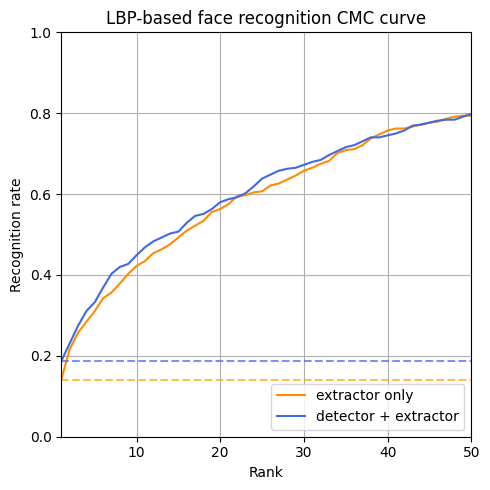

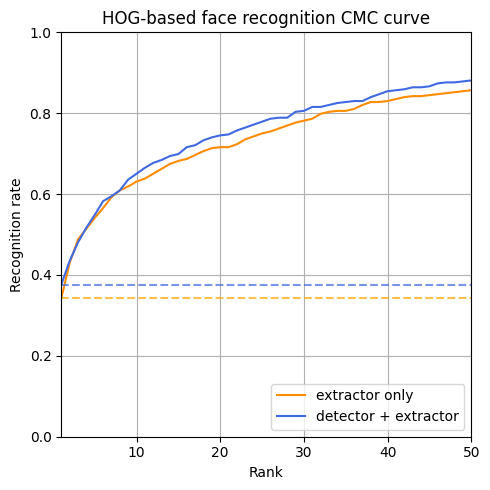

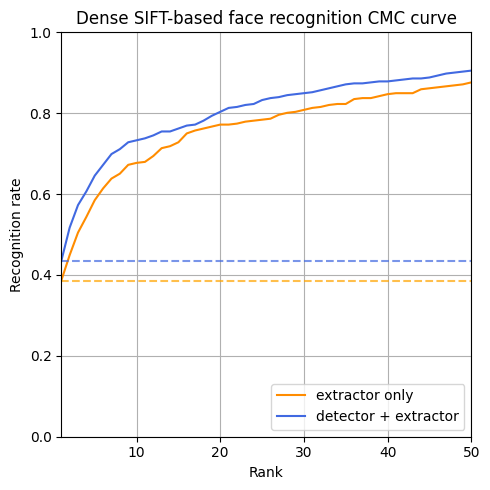

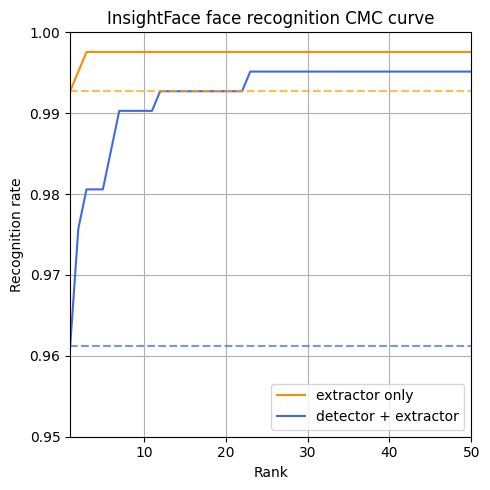

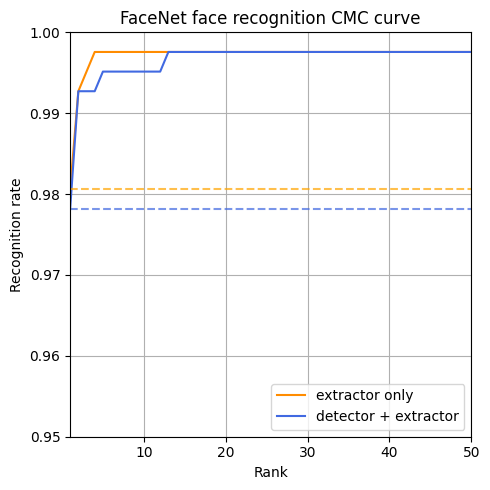

In [14]:
import matplotlib.pyplot as plt

OUT_DIR = '../out'
PLOT_DIR = '../plot'


def calculate_cmc(distance_matrix, labels):
    n_images = len(labels)
    cmc = np.zeros(n_images)
    for i in range(n_images):
        sorted_indices = np.argsort(distance_matrix[i])
        sorted_labels = labels[sorted_indices]

        # find first match
        rank_of_match = np.where(sorted_labels == labels[i])[0][0]

        # increment ranks <=
        cmc[rank_of_match:] += 1

    # normalize
    cmc /= n_images
    return cmc


def plot_cmc_curve_pair(feature_extractor, title, xlim=(1, 50), ylim=(0, 1)):
    distances = np.loadtxt(f"{OUT_DIR}/{feature_extractor}/distance_matrix.txt")
    labels = np.loadtxt(f"{OUT_DIR}/{feature_extractor}/labels.txt", dtype=str)
    n_images = len(labels)

    distances_detector = np.loadtxt(f"{OUT_DIR}/{feature_extractor}d/distance_matrix.txt")
    labels_detector = np.loadtxt(f"{OUT_DIR}/{feature_extractor}d/labels.txt", dtype=str)
    n_images_detector = len(labels_detector)

    # sanity check
    assert n_images == n_images_detector

    cmc = calculate_cmc(distances, labels)
    cmc_detector = calculate_cmc(distances_detector, labels_detector)

    # plot both curves
    os.makedirs(PLOT_DIR, exist_ok=True)

    plt.figure(figsize=(5, 5))
    plt.plot(range(1, n_images + 1), cmc, label="extractor only", color="darkorange")
    plt.plot(range(1, n_images + 1), cmc_detector, label="detector + extractor", color="royalblue")

    # mark rank-1 accuracies with dashed lines
    plt.axhline(y=cmc[0], color="orange", linestyle="--", alpha=0.7)
    plt.axhline(y=cmc_detector[0], color="royalblue", linestyle="--", alpha=0.7)

    plt.xlabel("Rank")
    plt.ylabel("Recognition rate")
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid()
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.tight_layout()
    plt.savefig(f"{PLOT_DIR}/{feature_extractor}_cmc_curve.png")
    plt.show()


plot_cmc_curve_pair("lbp", "LBP-based face recognition CMC curve")
plot_cmc_curve_pair("hog", "HOG-based face recognition CMC curve")
plot_cmc_curve_pair("sift", "Dense SIFT-based face recognition CMC curve")
plot_cmc_curve_pair("insight", "InsightFace face recognition CMC curve", ylim=(0.95, 1.0))
plot_cmc_curve_pair("facenet", "FaceNet face recognition CMC curve", ylim=(0.95, 1.0))

In [15]:
# test_iou, eval_time = detector.evaluate(test_df, IMG_DIR, 1.1, 7, (20, 20))
# print(f"Viola-Jones IoU score: {test_iou:.3f}, evaluation time: {eval_time:.3f} seconds")

```text
IoU score: 0.653, evaluation time: 28.072 seconds
```

In [16]:
test_iou, eval_time = yolov8_detector.evaluate(test_df, IMG_DIR)
print(f"YOLOv8 IoU score: {test_iou:.3f}, evaluation time: {eval_time:.3f} seconds")

YOLOv8 IoU score: 0.853, evaluation time: 30.946 seconds


```text
YOLOv8 IoU score: 0.853, evaluation time: 30.946 seconds
```

In [17]:
test_iou, eval_time = insight_detector.evaluate(test_df, IMG_DIR)
print(f"Insight IoU score: {test_iou:.3f}, evaluation time: {eval_time:.3f} seconds")

C:\Users\tjasa\miniconda3\envs\cv\Lib\site-packages\insightface\utils\transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


Insight IoU score: 0.861, evaluation time: 53.517 seconds


```text
Insight IoU score: 0.861, evaluation time: 53.517 seconds
```